In [ ]:
#pip install pmdarima

# State Space Model Using ARIMA Method
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

### Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

matplotlib.rcParams['figure.figsize'] = [8, 3]
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2


In [2]:
# Read in data
month = pd.read_excel('/Users/jasonrobinson/Documents/Projects/time_series_analysis/data/U.S. 10-yr-Bond.xls', parse_dates=['Date'], index_col='Date')
print(month.shape)
month.head()

(808, 1)


,Rate
Date,
1953-04-30,2.83
1953-05-31,3.05
1953-06-30,3.11
1953-07-31,2.93
1953-08-31,2.95



### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

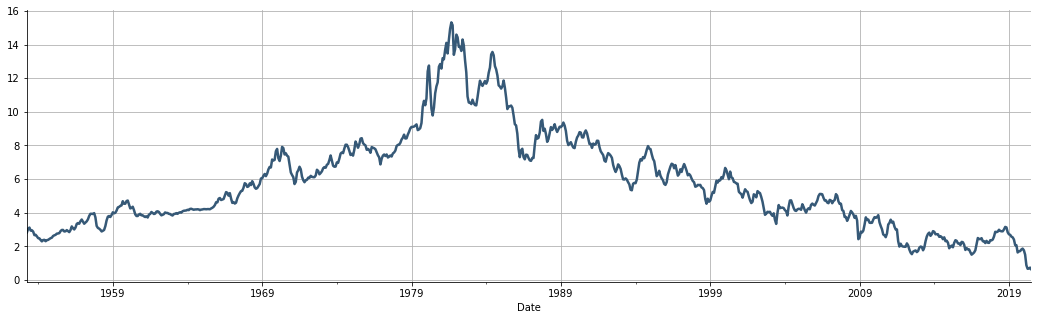

In [3]:
month['Rate'].plot(grid=True);

In [4]:
month['Rate'].dtype

dtype('float64')

In [92]:
month[month.index>'2018']

,Rate
Date,
2018-01-31,2.58
2018-02-28,2.86
2018-03-31,2.84
2018-04-30,2.87
2018-05-31,2.98
2018-06-30,2.91
2018-07-31,2.89
2018-08-31,2.89
2018-09-30,3.00


In [89]:
month_20 = month[month.index=='2018-31-01']
month_20

,Rate
Date,


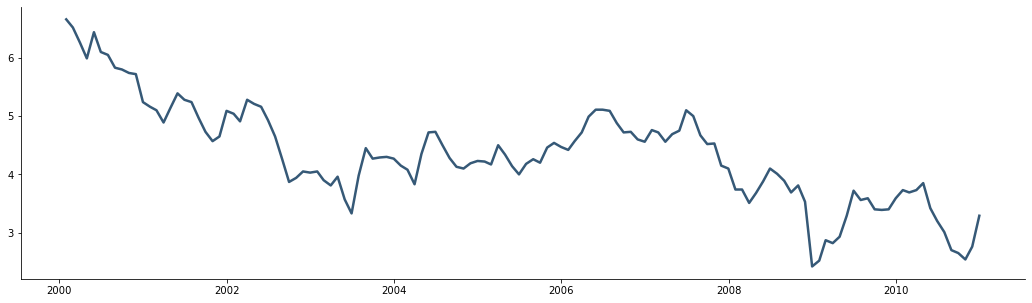

In [6]:
# 10-year period (2000-2010)
plt.plot(month['2000':'2010']['Rate']);

In [ ]:
# 10-year period (2010-2020)
plt.plot(month['2010':'2020']['Rate']);

In [ ]:
# Comparing 2 previous decades
plt.scatter(month['1990':'2000'][['Rate']], month['2000':'2010'][['Rate']]);

In [ ]:
month['1990':'2000'][['Rate']].head()

In [ ]:
month['2000':'2010'].plot();

In [ ]:
plt.plot(month['2010':'2018'][['Rate']]);


### Test for Stationarity

For us to be capable of applying an **ARIMA** method, we will first need to add stationarity. First let's confirm that our time series is not stationary. A few methods exist for this, but we will use the **KPSS** method.



In [7]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month['Rate'])

(0.7319408103900956, True)

In [8]:
from statsmodels.tsa.stattools import adfuller


def adf_test(month):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(month, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    

    
adf_test(month)

Results of Dickey-Fuller Test:
Test Statistic                  -0.860881
p-value                          0.800582
#Lags Used                      21.000000
Number of Observations Used    786.000000
Critical Value (1%)             -3.438697
Critical Value (5%)             -2.865224
Critical Value (10%)            -2.568732
dtype: float64


In [9]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
    
kpss_test(month)

Results of KPSS Test:
Test Statistic            0.928395
p-value                   0.010000
Lags Used                18.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


In [10]:
# Reject the null hypothesis - test statistic actual pvalue smaller
#sm.tsa.stattools.kpss(month, regression='ct')

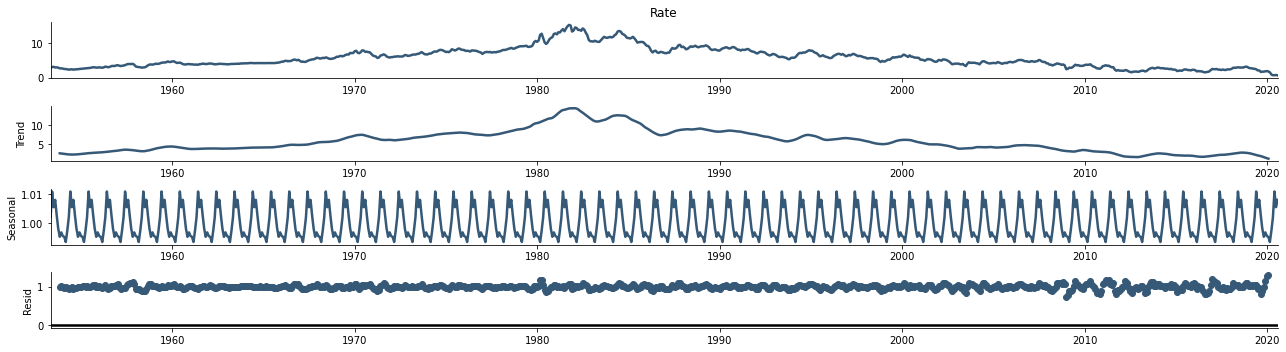

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

seas_dcomp = seasonal_decompose(month['Rate'],period=12,model='multiplicative')
seas_dcomp.plot();


### Make Series Stationary


In [ ]:
# Possiblel alternative
lag_acf = acf(month_diff, lags)

In [12]:
#Transform the data from non-statinary to stationary
month_log = np.sqrt(month)
month_diff = month_log.diff().dropna()

In [13]:
# Check for stationarity
result = adfuller(month_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -14.931696
p-value: 0.000000
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [14]:
result_kpss_ct_log=kpss(month_diff,regression="ct")
print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
print('p-value: %f' %result_kpss_ct_log[1])
print('Critical values:')
for key, value in result_kpss_ct_log[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.030000
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


In [15]:
month_new = month['Rate']
month_24 = month_new[777:-7]
month_24.shape

(24,)

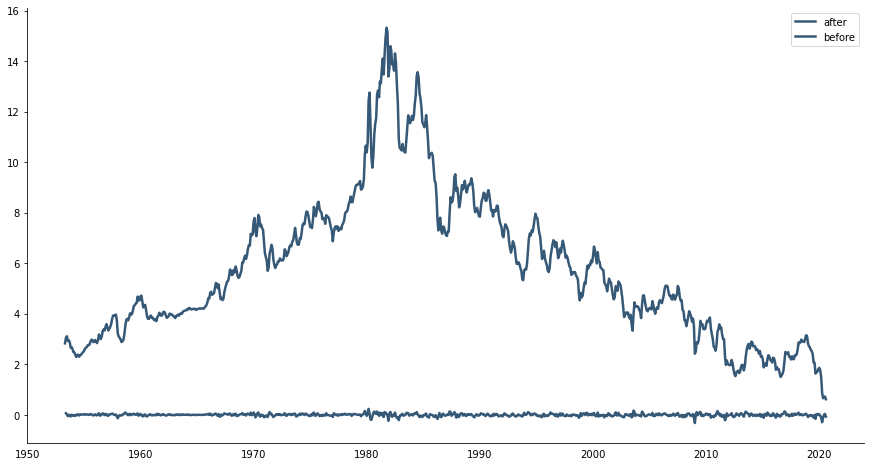

In [29]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month,label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()

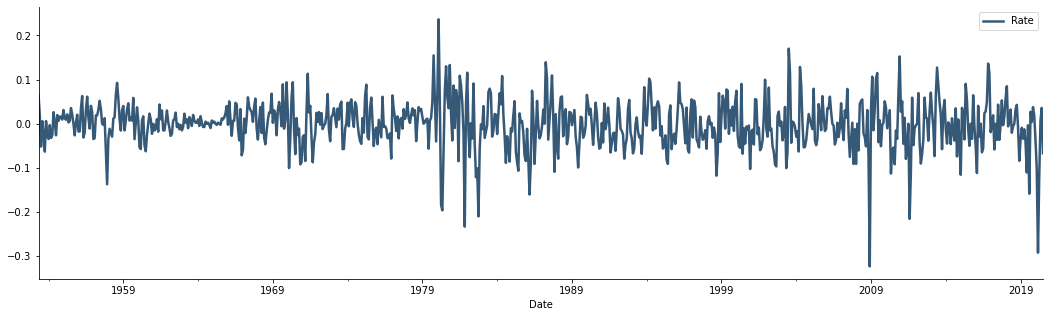

In [19]:
# Closer display
month_diff.plot()
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.show();


### ACF/PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [ ]:
# First order 
#month['Rate_diff'] = month['Rate'].diff(periods=12)
#month['Rate'] = month.dropna()

In [43]:
# Autocorrelation
acf_month = acf(month['Rate'])
acf_month

TypeError: 'numpy.ndarray' object is not callable

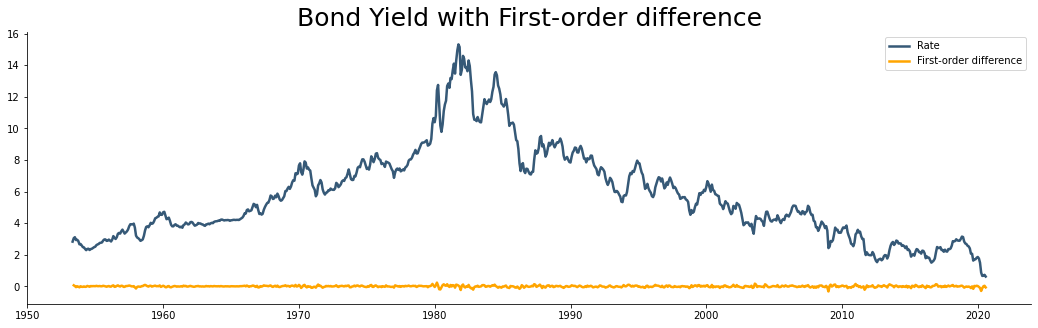

In [24]:
# Visualize our plots
plt.title('Bond Yield with First-order difference', size=25)
plt.plot(month['Rate'], label='Rate')
plt.plot(month_diff, label='First-order difference', color='orange')
plt.legend();

Nice, we can definitely tell the difference, but let's see if we can do better

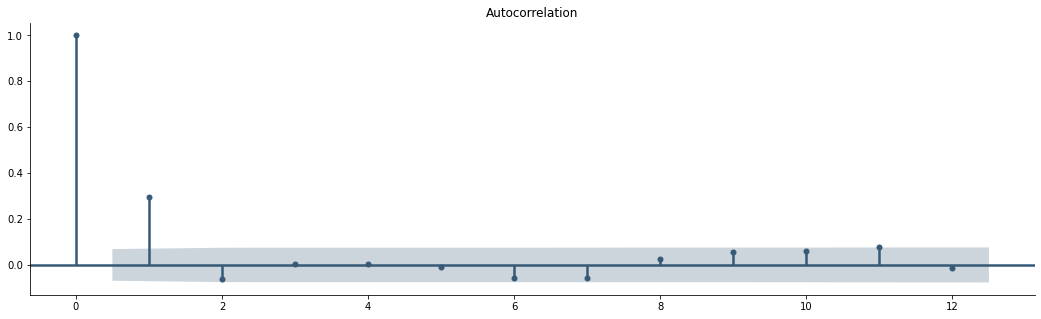

In [36]:
plot_acf(month_diff, lags=12);

Most important is 1

In [39]:
# Partial autocorrelation
pacf_month = pacf(month['Rate'])
pacf_month.round(2)

array([ 1.  ,  0.99, -0.22,  0.12, -0.03,  0.02, -0.02,  0.04,  0.05,
       -0.07, -0.03, -0.05, -0.07,  0.08, -0.  ,  0.06,  0.05,  0.01,
        0.03, -0.03,  0.03,  0.09,  0.08, -0.05, -0.04,  0.03,  0.02,
       -0.01,  0.01, -0.  , -0.02, -0.03,  0.01, -0.  , -0.05, -0.01,
        0.  ,  0.01,  0.01,  0.  , -0.01])

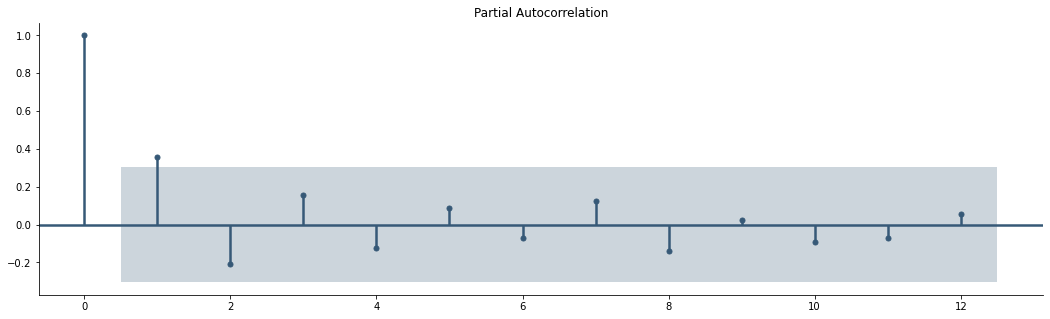

In [41]:
plot_pacf(pacf_month, lags=12);

In [ ]:
plt.title('Bond Yield with First-order difference', size=25)
plt.plot(month['Rate'], label='Rate')
plt.plot(month_diff, label='First-order difference', color='orange')
plt.legend();


## Auto-ARIMA

In [ ]:
# 24-month period
#test = month['Rate'][777:-7]
#test.shape

In [44]:
from pmdarima import auto_arima

month_fit = auto_arima(month_diff,start_p=0, d=1, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 50 )

month_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-1868.405, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-2145.516, Time=1.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-1870.353, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-1929.374, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-2248.811, Time=2.66 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=-2290.350, Time=6.93 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=13.22 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.66 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=-2217.991, Time=4.39 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=-2318.792, Time=6.54 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-2274.076, Time=6.11 sec
 ARIMA(2,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=14.07 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.71 sec
 ARIMA(3,0,0)(3,1,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  807
Model:             SARIMAX(3, 0, 1)x(3, 1, 1, 12)   Log Likelihood                1224.315
Date:                            Fri, 08 Jul 2022   AIC                          -2428.631
Time:                                    21:28:31   BIC                          -2381.847
Sample:                                         0   HQIC                         -2410.653
                                            - 807                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0003      0.000     -0.825      0.409      -0.001       0.000
ar.L1          0.0287      0.391      0.073      0.942      -0.738       0.795
ar.L2         -0.0737      0.140     -0.527      0.598      -0.348       0.201
ar.L3          0.0141      0.080      0.177      0.860      -0.142       0.170
ma.L1          0.3291      0.390      0.843      0.399      -0.436       1.094
ar.S.L12      -0.0464      0.044     -1.051      0.293      -0.133       0.040
ar.S.L24      -0.1539      0.041     -3.765      0.000      -0.234      -0.074
ar.S.L36       0.0273      0.047      0.579      0.562      -0.065       0.120
ma.S.L12      -0.8810      0.035    -24.963      0.000      -0.950      -0.812
sigma2         0.0026   9.42e-05     27.846      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               365.48
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               3.40   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


## SARIMAX

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the other is P,D,Q,m to accountfor seasonality.

In [52]:
# Split data into train / test sets
train = month_diff.iloc[:len(month_diff)-12]
test = month_diff.iloc[len(month_diff)-12:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train, 
                order = (2, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.31582D+00    |proj g|=  5.16749D+00

At iterate    5    f= -1.37249D+00    |proj g|=  7.68740D-02

At iterate   10    f= -1.38185D+00    |proj g|=  1.86735D+00

At iterate   15    f= -1.39090D+00    |proj g|=  7.47223D-01

At iterate   20    f= -1.44325D+00    |proj g|=  9.99559D-01

At iterate   25    f= -1.46945D+00    |proj g|=  2.37121D+00

At iterate   30    f= -1.51952D+00    |proj g|=  1.49742D+00

At iterate   35    f= -1.52416D+00    |proj g|=  2.90483D-01

At iterate   40    f= -1.53946D+00    |proj g|=  1.94731D-01

At iterate   45    f= -1.54250D+00    |proj g|=  1.81039D-01

At iterate   50    f= -1.54312D+00    |proj g|=  2.75171D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Rate   No. Observations:                  795
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                1226.782
Date:                            Fri, 08 Jul 2022   AIC                          -2439.564
Time:                                    21:38:42   BIC                          -2406.931
Sample:                                05-31-1953   HQIC                         -2427.014
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3372      0.028     12.144      0.000       0.283       0.392
ar.L2         -0.1837      0.030     -6.147      0.000      -0.242      -0.125
ma.L1         -0.9972      0.022    -45.696      0.000      -1.040      -0.954
ar.S.L12      -0.0322      0.034     -0.953      0.340      -0.099       0.034
ar.S.L24      -0.0332      0.034     -0.964      0.335      -0.101       0.034
ma.S.L12      -0.9985      0.296     -3.369      0.001      -1.579      -0.418
sigma2         0.0024      0.001      3.524      0.000       0.001       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               304.48
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


### Alternate version


In [61]:
mod = sm.tsa.statespace.SARIMAX(month['Rate'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.Rate   No. Observations:                  795
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -197.806
Date:                            Fri, 08 Jul 2022   AIC                            403.613
Time:                                    23:31:58   BIC                            422.326
Sample:                                05-31-1954   HQIC                           410.804
                                     - 07-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3582      0.020     18.041      0.000       0.319       0.397
ar.L2         -0.2083      0.023   

In [65]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [98]:
# Dynamic predictions
predict_dy = res.get_prediction(dynamic=2018)
predict_dy_ci = predict_dy.conf_int()

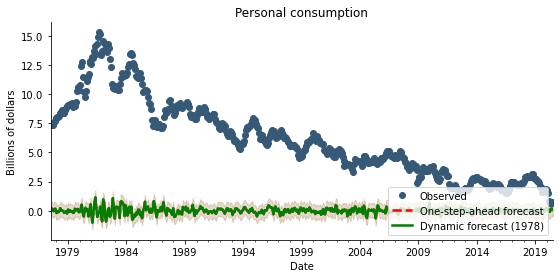

In [99]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
month.loc['1977-07-01':, 'Rate'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

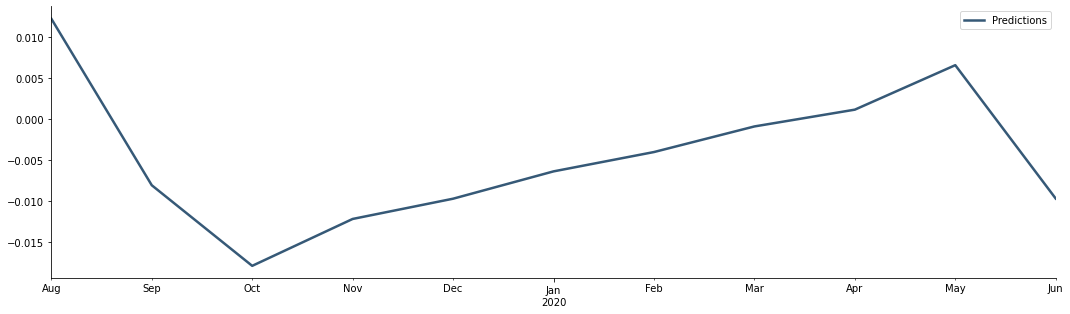

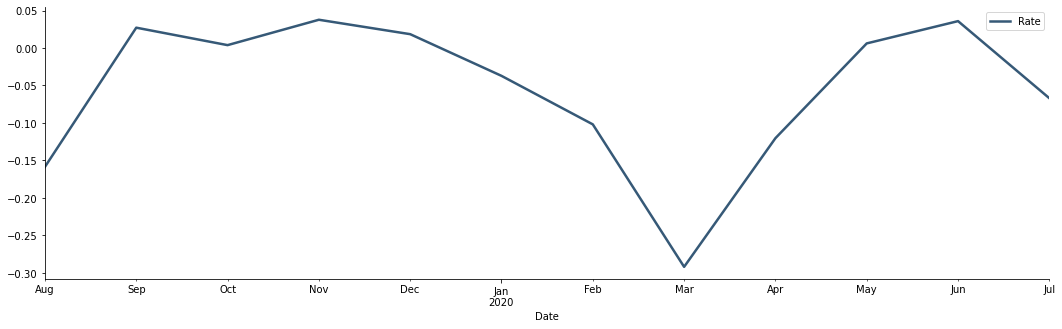

In [100]:
start = len(train)
end = len(train[:-1]) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

In [51]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse(test, predictions)
mean_squared_error(test, predictions)

0.014171903180280795

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23548D+00    |proj g|=  4.57091D+00


 This problem is unconstrained.



At iterate    5    f= -1.28655D+00    |proj g|=  6.10886D-01

At iterate   10    f= -1.33985D+00    |proj g|=  3.30358D+00

At iterate   15    f= -1.44563D+00    |proj g|=  3.21949D-01

At iterate   20    f= -1.45785D+00    |proj g|=  1.47262D-01

At iterate   25    f= -1.45926D+00    |proj g|=  2.41717D-02

At iterate   30    f= -1.45943D+00    |proj g|=  4.44526D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     48      1     0     0   6.075D-03  -1.459D+00
  F =  -1.4594343385169082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


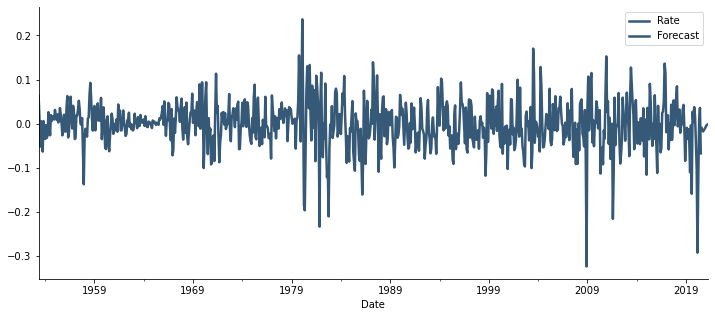

In [103]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 3
                          , 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);
